# Model Evaluation and Testing
**Project Assumption:** The target model is SVM

### Table of Contents
1. Data Loading
    - 1.1 Library Import
    - 1.2 Data and Model Loading
2. Predictions
3. Global Performance Evaluation
    - 3.2 Confusion Matrix
    - 3.3 ROC and Precision-Recall Curve
4. Feature Importance
5. Model Architecture
6. Reliability
7. Error Analysis
    - 7.1 Errors Segmentation
    - 7.2 `age` and `weeks_worked` distribution
    - 7.3 `education` and `major_occ_code` distribution
    - 7.4 `capital_gain` and `stock_dividends` distribution
    - 7.5 `num_emp` distribution
8. Conclusions 

## 1. Data Loading

### 1.1 Library Import

In [4]:
import warnings
import joblib
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.calibration import calibration_curve
from sklearn.cluster import KMeans
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    average_precision_score
)
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### 1.2 Data and Model Loading

In [2]:
df_test = pd.read_parquet('data/test.parquet')
df_train = pd.read_parquet('data/train.parquet')

model = joblib.load('final_model.pkl')

X_test = df_test.drop(columns=['income_50k'])
y_test_raw = df_test['income_50k']
X_train = df_train.drop(columns=['income_50k'])
y_train_raw = df_train['income_50k']

## 2. Predictions

 To ensure consistency in the target variable's encoding between the training and testing datasets, we load the LabelEncoder that was previously fitted on the training data. This guarantees that the same integer labels are assigned to the corresponding income categories.

In [3]:
le = joblib.load('income_label_encoder.joblib')
y_test = le.transform(y_test_raw)
y_train = le.transform(y_train_raw)
print("Running predictions...")
y_pred = model.predict(X_test)
print("Predictions Ready")

Running predictions...
Predictions Ready


## 3. Global Performance Evaluation

### 3.1 Confusion Matrix

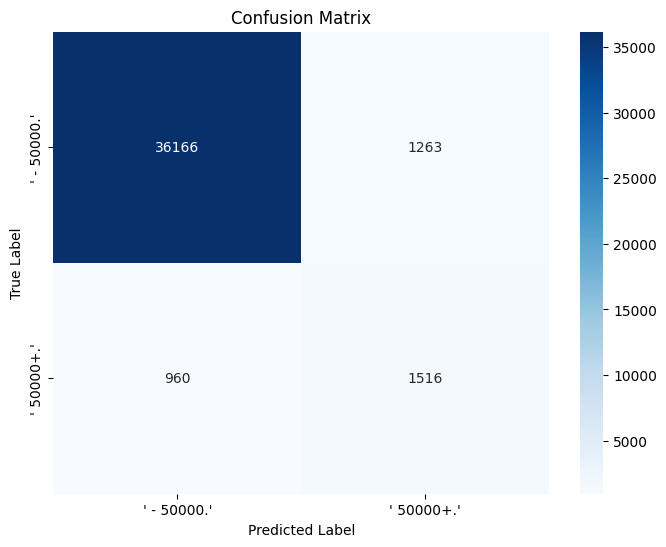


Classification Report:
              precision    recall  f1-score   support

 ' - 50000.'       0.97      0.97      0.97     37429
  ' 50000+.'       0.55      0.61      0.58      2476

    accuracy                           0.94     39905
   macro avg       0.76      0.79      0.77     39905
weighted avg       0.95      0.94      0.95     39905

Average Precision Score: 0.6181


In [7]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

y_pred_proba = model.predict_proba(X_test)[:, 1]
ap_score = average_precision_score(y_test, y_pred_proba)
print(f"Average Precision Score: {ap_score:.4f}")

### Observations:

*   **Accuracy vs. Imbalance:** The model achieves high overall accuracy. However, this metric is heavily influenced by the significant class imbalance, as the majority class (`<=50K`) dominates the dataset.
*   **Minority Class Complexity:** The minority class (`>50K`) shows moderate Precision and Recall, reflecting a challenging trade-off. As established in the `model_optimization` phase, the dataset features are intrinsically difficult to distinguish, limiting the distinctness of the classes despite model tuning.

### 3.2 ROC and Precision-Recall Curve


ROC AUC Score: 0.9270


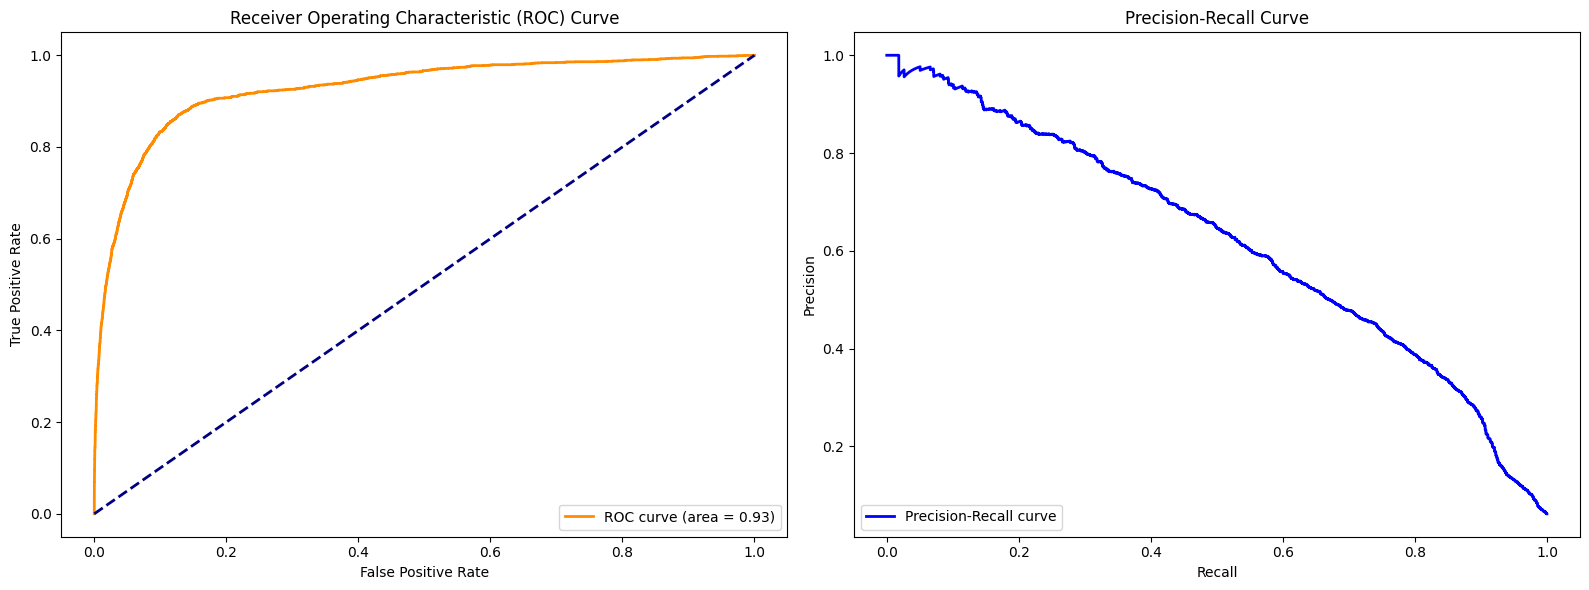

In [ ]:
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {auc_score:.4f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax1.legend(loc="lower right")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
ax2.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve')
ax2.legend(loc="lower left")
plt.tight_layout()
plt.show()

### Observations:
- **Strong Discriminatory Power:** The ROC AUC score of approximately 0.93 indicates that the model has strong discriminatory power.
- **Precision-Recall Trade-off:** The Precision-Recall curve highlights the challenges of class imbalance. There is a clear trade-off: improving precision (reducing false positives) often comes at the cost of recall (missing truepositives). The curve's shape shows that achieving high precision and high recall simultaneously is difficult.

## 4. Feature Importance - SHAP

Loading data and model...
Transforming data...
Preparing background data with KMeans...
Initializing SHAP KernelExplainer...
Calculating SHAP values for the first 100 samples...


100%|██████████| 100/100 [03:53<00:00,  2.33s/it]


Retrieving feature names...
Success! Feature names matched.
Generating plot...


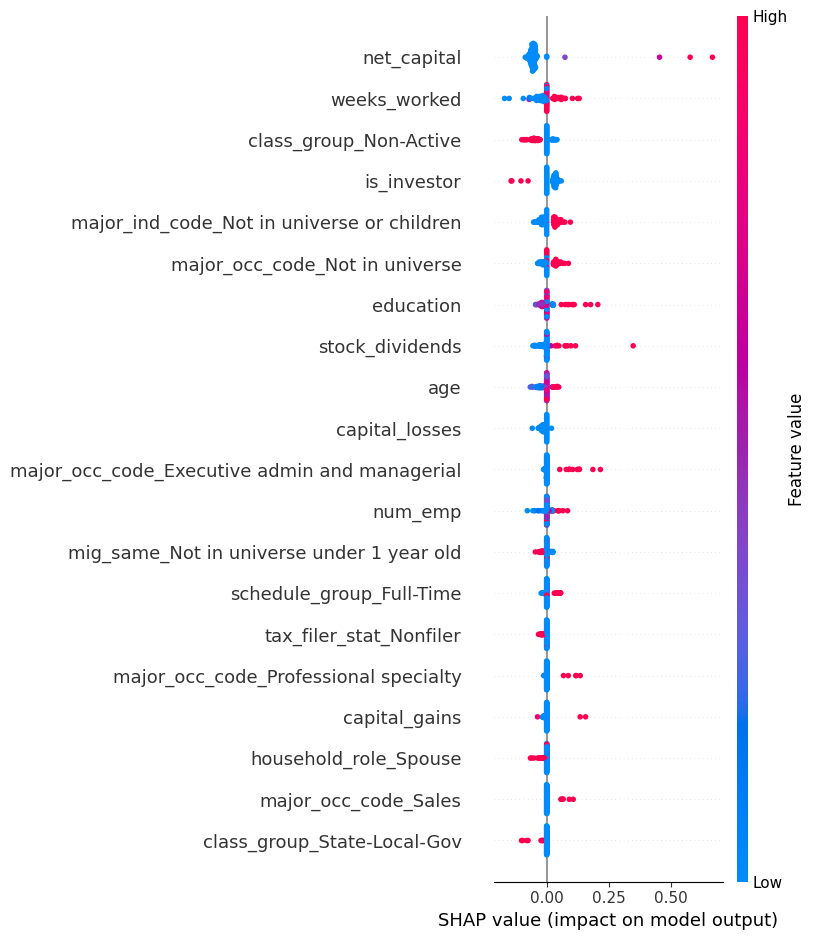

In [6]:
def force_dense_numpy(data):
    if scipy.sparse.issparse(data):
        return data.toarray()
    if hasattr(data, "values"):
        return np.array(data.values)
    return np.array(data)

print("Loading data and model...")
df_test = pd.read_parquet('data/test.parquet')
df_train = pd.read_parquet('data/train.parquet')
model = joblib.load('final_model.pkl')

X_test = df_test.drop(columns=['income_50k'])
X_train = df_train.drop(columns=['income_50k'])

svm_step = model.named_steps['svm']
preprocessing_steps = [s for s in model.steps if s[0] not in ['undersampler', 'svm']]
preprocessor = Pipeline(preprocessing_steps)

print("Transforming data...")
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

X_train_numpy = force_dense_numpy(X_train_transformed).astype(float)
X_test_numpy = force_dense_numpy(X_test_transformed).astype(float)

print("Preparing background data with KMeans...")
kmeans = KMeans(n_clusters=50, random_state=42, n_init=10).fit(X_train_numpy)
background_data = kmeans.cluster_centers_

print("Initializing SHAP KernelExplainer...")
explainer = shap.KernelExplainer(svm_step.predict_proba, background_data)

NSAMPLES = 100
print(f"Calculating SHAP values for the first {NSAMPLES} samples...")
shap_values = explainer.shap_values(X_test_numpy[:NSAMPLES])

vals_to_plot = None
if isinstance(shap_values, list):
    vals_to_plot = shap_values[1]
elif isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 3:
    vals_to_plot = shap_values[:, :, 1]
else:
    vals_to_plot = shap_values

print("Retrieving feature names...")
feature_names = []

try:
    feature_names = preprocessor.get_feature_names_out()
except:
    pass

if len(feature_names) != X_test_numpy.shape[1]:
    try:
        last_step = preprocessor.steps[-1][1] 
        if hasattr(last_step, 'get_feature_names_out'):
             feature_names = last_step.get_feature_names_out()
    except:
        pass

if len(feature_names) != X_test_numpy.shape[1]:
    print(f"WARNING: Could not automatically match feature names. Found {len(feature_names)} names for {X_test_numpy.shape[1]} columns.")
    feature_names = [f"Feature {i}" for i in range(X_test_numpy.shape[1])]
else:
    print("Success! Feature names matched.")

print("Generating plot...")
plt.figure()
shap.summary_plot(vals_to_plot, X_test_numpy[:NSAMPLES], feature_names=feature_names)

### SHAP Analysis

**1. Dominance of Engineered Features**
*   **`net_capital` (Rank 1):** The single most decisive predictor. High values strongly drive predictions towards the high-income class, validating that aggregated capital status is a superior predictor to isolated gains/losses.
*   **`is_investor` (Rank 4):** A strong positive signal indicating that mere participation in investments is a key differentiator for high earners.

**2. Labor and Employment Dynamics**
*   **`weeks_worked` (Rank 2):** Shows a strong positive correlation; work consistency significantly increases high-income probability.
*   **`class_group_Non-Active` (Rank 3):** Acts as a strong negative filter. Being outside the workforce (e.g., children, retirees) significantly reduces the likelihood of a high-income prediction.

**3. Demographic and Socio-Economic Indicators**
*   **`education` & `age`:** Both follow expected patterns where higher education and age contribute positively, reflecting the accumulation of skills and experience.
*   **Occupation Type:** Specific roles (Executive, Professional) are positive predictors, while generic or "Not in universe" categories act as negative signals.

**Conclusion:**
The model relies heavily on financial health and workforce participation rather than noise. The top ranking of custom features (`net_capital`, `class_group`) confirms that the feature engineering phase successfully extracted high-value signals.

## 5. Model Architecture

In [15]:
svc_model = model.steps[-1][1] 

print(f"{' Hyperparameter Review ':=^40}")
print(f"C (Regularization):  {svc_model.C}")
print(f"Kernel:              {svc_model.kernel}")
print(f"Gamma:               {svc_model.gamma}")

n_support_vectors = svc_model.n_support_.sum()

n_original_samples = len(df_train)
sv_ratio = n_support_vectors / n_original_samples

print(f"\n{' Support Vector Analysis ':=^40}")
print(f"Total Support Vectors:     {n_support_vectors:,}")
print(f"Original Training Samples: {n_original_samples:,}")
print(f"SV Ratio (vs Original):    {sv_ratio:.2%}")

======== Hyperparameter Review =========
C (Regularization):  800
Kernel:              rbf
Gamma:               0.0009

======= Support Vector Analysis ========
Total Support Vectors:     13,281
Original Training Samples: 159,618
SV Ratio (vs Original):    8.32%


**The Support Vector Ratio** is  ~8%. This means only a small fraction of the training data points are needed to define the decision boundary. This indicates good data compression and suggests the model is efficient.

## 6. Predicted Probability Distribution

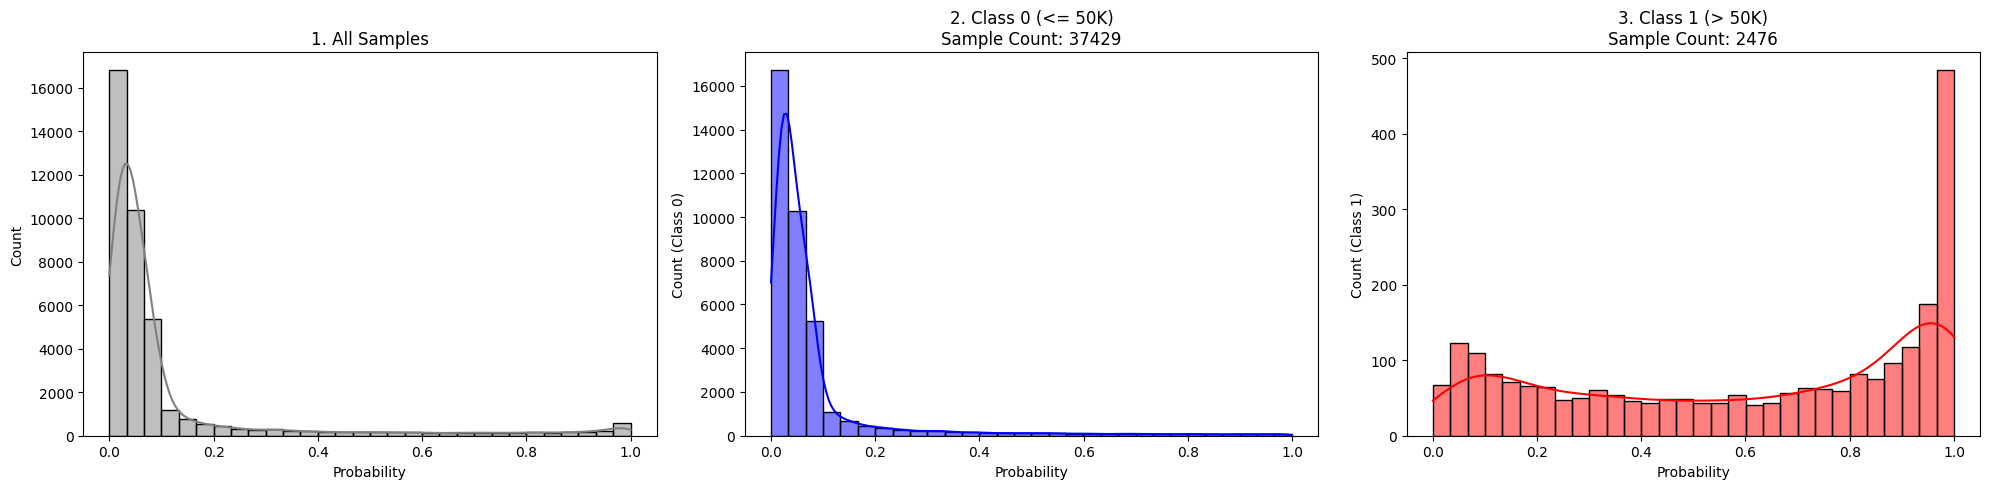

In [16]:
df_viz = pd.DataFrame({
    'Probability': y_pred_proba,
    'True Label': y_test
})

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

sns.histplot(data=df_viz, x='Probability', bins=30, ax=axes[0], color='gray', kde=True)
axes[0].set_title('1. All Samples')
axes[0].set_ylabel('Count')

subset_0 = df_viz[df_viz['True Label'] == 0]
sns.histplot(data=subset_0, x='Probability', bins=30, ax=axes[1], color='blue', kde=True)
axes[1].set_title(f'2. Class 0 (<= 50K)\nSample Count: {len(subset_0)}')
axes[1].set_ylabel('Count (Class 0)')

subset_1 = df_viz[df_viz['True Label'] == 1]
sns.histplot(data=subset_1, x='Probability', bins=30, ax=axes[2], color='red', kde=True)
axes[2].set_title(f'3. Class 1 (> 50K)\nSample Count: {len(subset_1)}')
axes[2].set_ylabel('Count (Class 1)')

plt.tight_layout()
plt.show()

**The probability distributions** show the model is quite confident in its predictions for the majority class ('<=50K'), with probabilities clustering near zero. For the minority class ('>50K'), predictions are less certain and more spread out. This is a direct consequence of the class imbalance; the model has had fewer examples of the positive class to learn from.

### 7. Calibration Curve

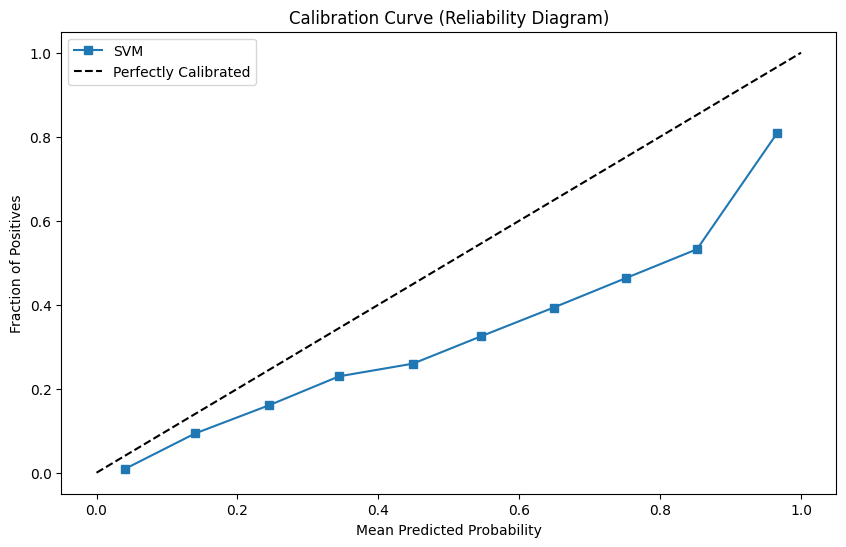

In [11]:
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='uniform')

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, 's-', label='SVM')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Reliability Diagram)')
plt.legend()
plt.show()

The calibration curve lies below the "Perfectly Calibrated" diagonal, indicating that the model is generally overconfident. Probabilities should not be interpreted as true probabilities without calibration.

## 7. Error Analysis

### 7.1 Errors Segmentation

In [17]:
results_df = X_test.copy()
results_df['true_label'] = y_test
results_df['predicted_label'] = y_pred
results_df['predicted_proba'] = y_pred_proba
errors_df = results_df[results_df['true_label'] != results_df['predicted_label']]
fp_df = errors_df[errors_df['true_label'] == 0]
fn_df = errors_df[errors_df['true_label'] == 1]


### 7.2 `age` and `weeks_worked` distribution

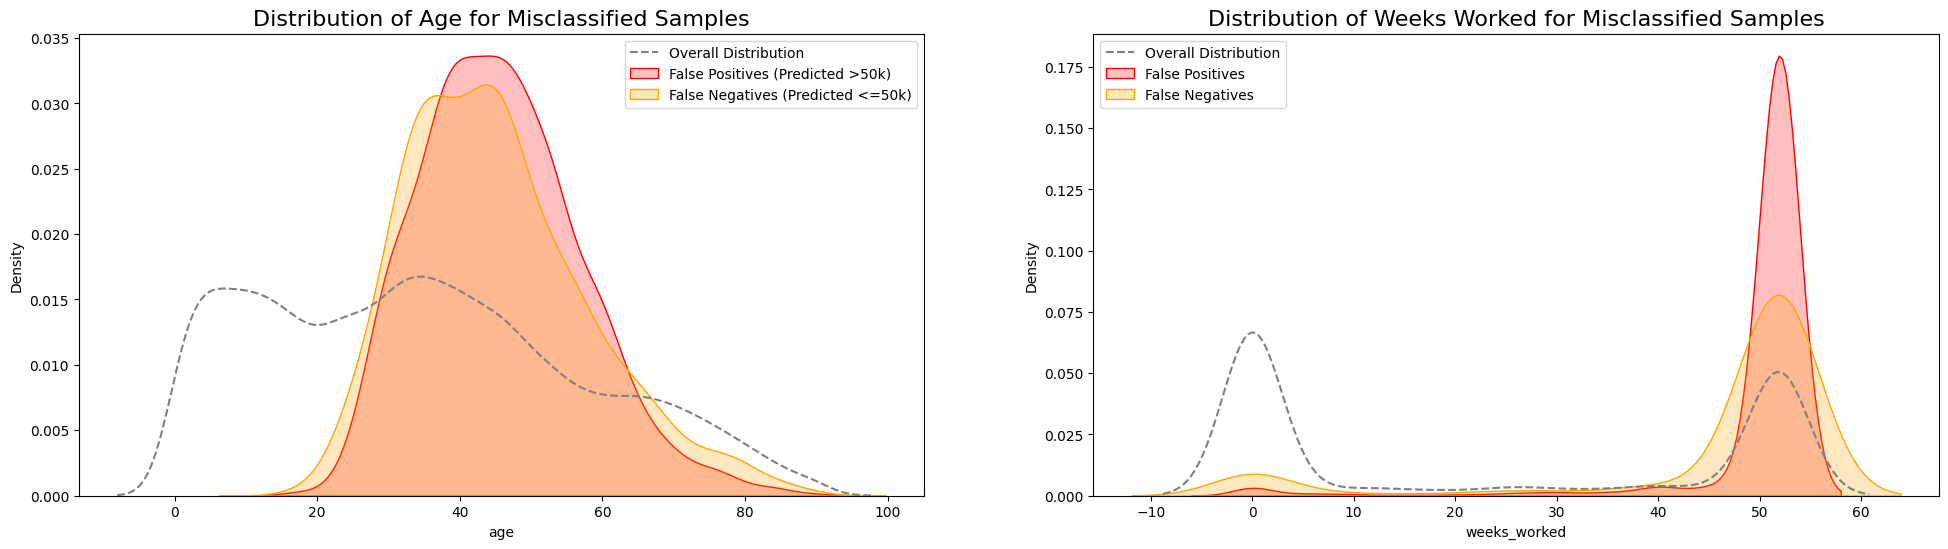

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

sns.kdeplot(results_df['age'], label='Overall Distribution', color='gray', linestyle='--', ax=axes[0])
sns.kdeplot(fp_df['age'], label='False Positives (Predicted >50k)', color='red', fill=True, ax=axes[0])
sns.kdeplot(fn_df['age'], label='False Negatives (Predicted <=50k)', color='orange', fill=True, ax=axes[0])
axes[0].set_title('Distribution of Age for Misclassified Samples', fontsize=16)
axes[0].legend()

sns.kdeplot(results_df['weeks_worked'], label='Overall Distribution', color='gray', linestyle='--', ax=axes[1])
sns.kdeplot(fp_df['weeks_worked'], label='False Positives', color='red', fill=True, ax=axes[1])
sns.kdeplot(fn_df['weeks_worked'], label='False Negatives', color='orange', fill=True, ax=axes[1])
axes[1].set_title('Distribution of Weeks Worked for Misclassified Samples', fontsize=16)
axes[1].legend()

plt.show()
print("\n")

### Observations:
- **False Positives (Age):** The model is more likely to misclassify **middle-aged individuals** (peaking between 40 and 50) as having high income when they do not. This suggests the model relies heavily on age as a proxy for wealth, assuming that older individuals naturally earn >50k, leading to errors when they do not.
- **False Negatives (Age):** Conversely, false negatives are concentrated in a slightly **younger demographic** (peaking around 35-40). The model frequently predicts these individuals have low income (<=50k) when they actually earn more. This indicates the model fails to capture specific signals of high earning potential (like specialized tech or finance roles) in younger professionals.
- **False Negatives (Weeks Worked):** A significant concentration of false negatives occurs for individuals who worked the **full 52 weeks**. The model incorrectly predicts a low income for many people with full-year employment. This implies that "weeks worked" alone is not a strong enough discriminator for the model; it struggles to distinguish between low-wage and high-wage full-time employees without stronger signals from other features.

### 7.3 `education` and `major_occ_code` distribution

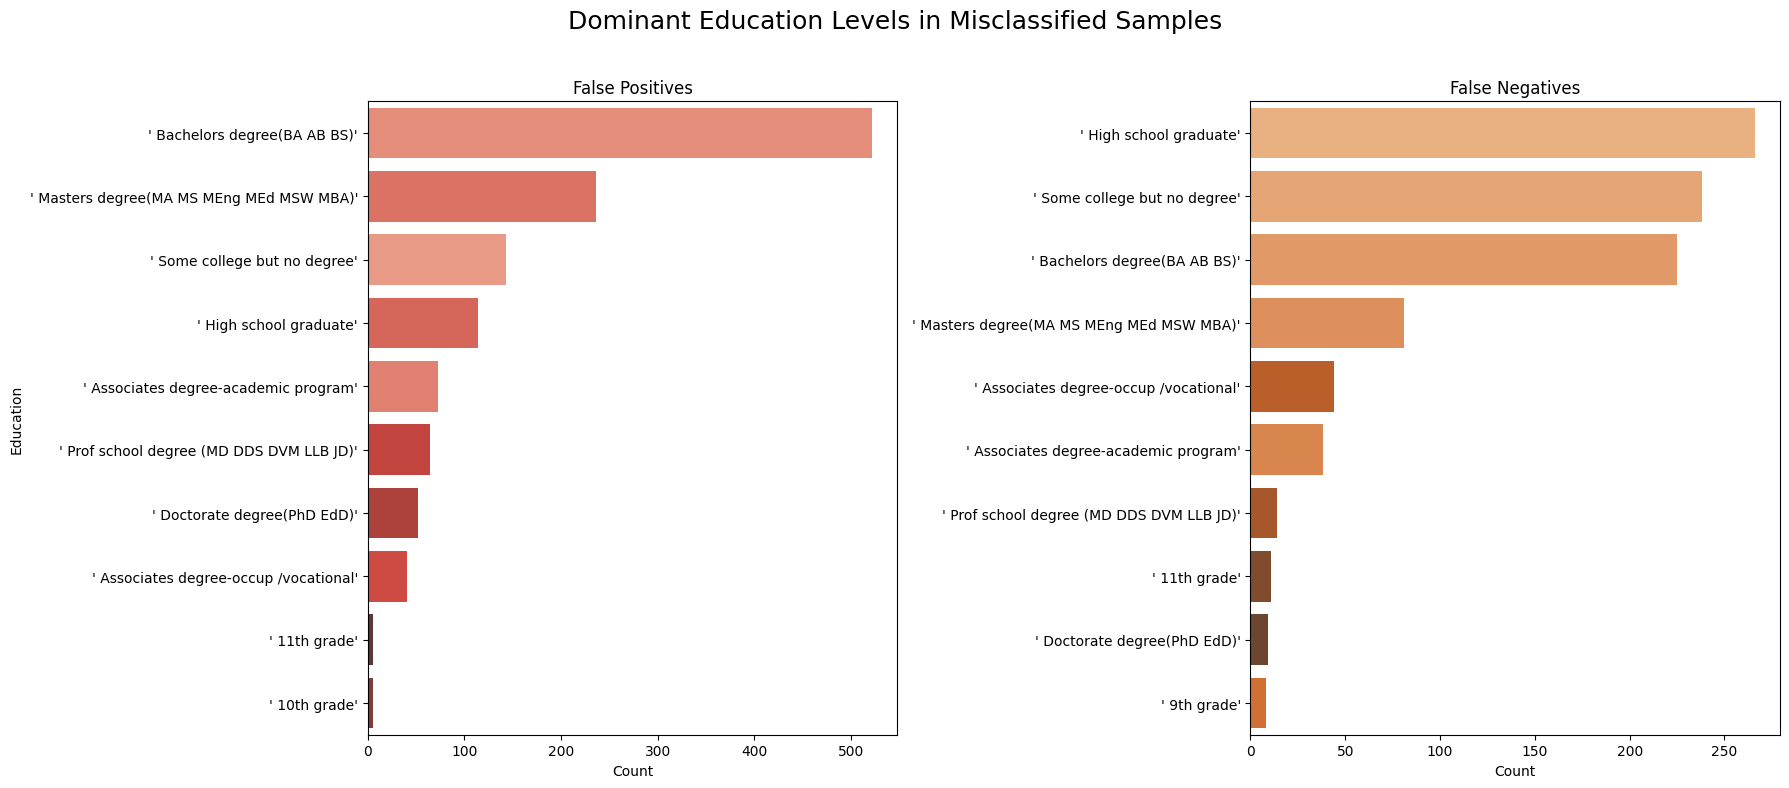

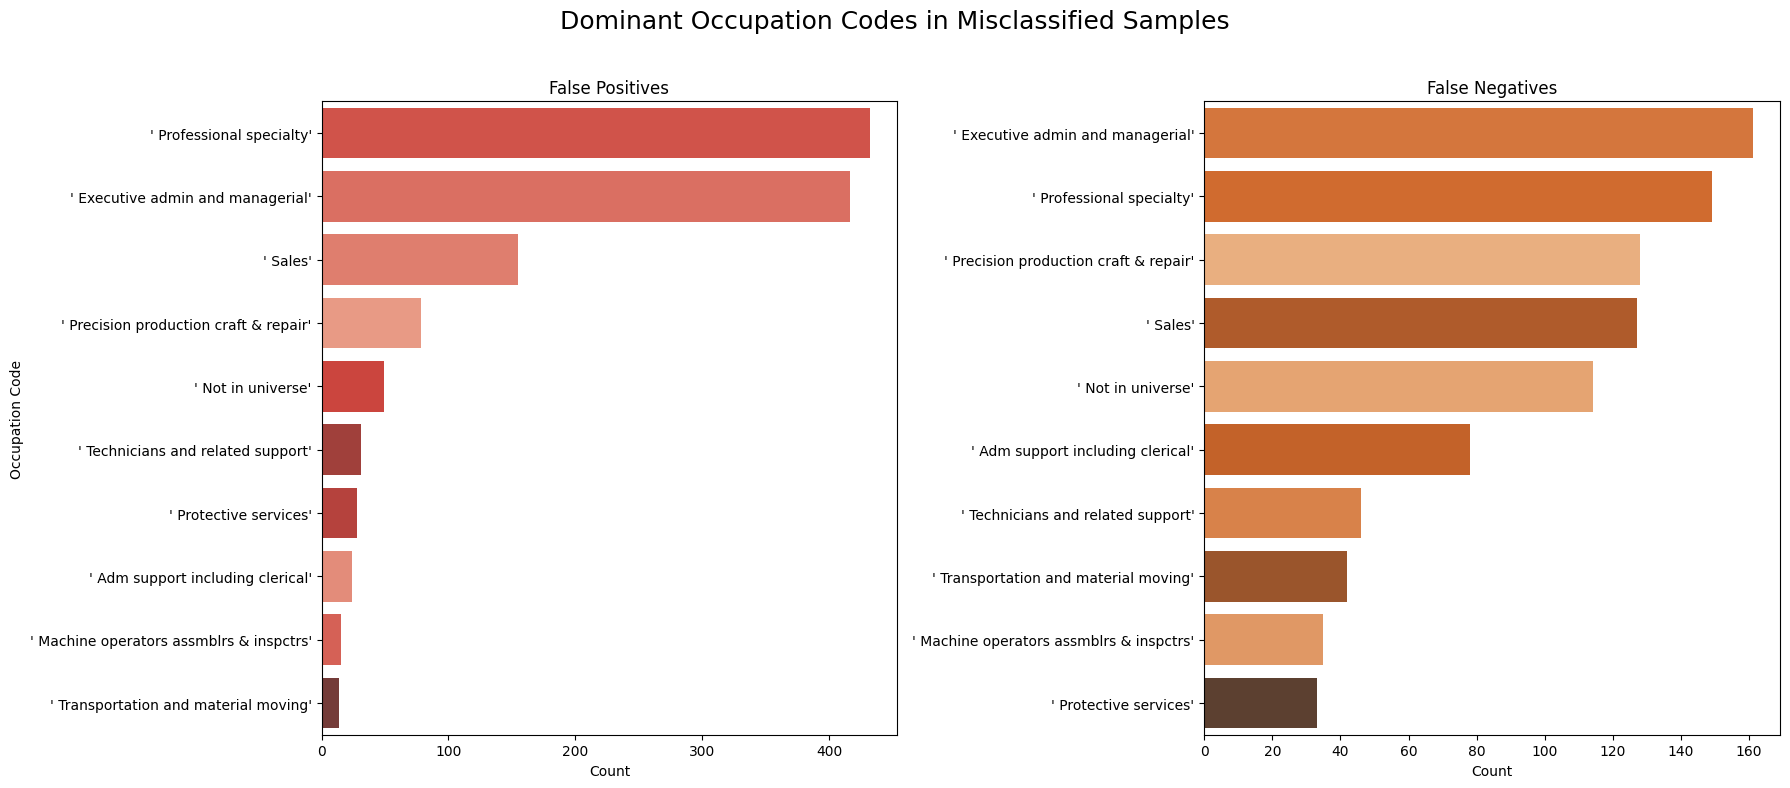

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
plt.suptitle("Dominant Education Levels in Misclassified Samples", fontsize=18)

sns.countplot(y=fp_df['education'], ax=ax1, order=fp_df['education'].value_counts().index[:10], palette='Reds_d', hue=fp_df['education'], legend=False)
ax1.set_title('False Positives')
ax1.set_xlabel('Count')
ax1.set_ylabel('Education')


sns.countplot(y=fn_df['education'], ax=ax2, order=fn_df['education'].value_counts().index[:10], palette='Oranges_d', hue=fn_df['education'], legend=False)
ax2.set_title('False Negatives')
ax2.set_xlabel('Count')
ax2.set_ylabel('')


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
plt.suptitle("Dominant Occupation Codes in Misclassified Samples", fontsize=18)

sns.countplot(y=fp_df['major_occ_code'], ax=ax1, order=fp_df['major_occ_code'].value_counts().index[:10], palette='Reds_d', hue=fp_df['major_occ_code'], legend=False)
ax1.set_title('False Positives')
ax1.set_xlabel('Count')
ax1.set_ylabel('Occupation Code')


sns.countplot(y=fn_df['major_occ_code'], ax=ax2, order=fn_df['major_occ_code'].value_counts().index[:10], palette='Oranges_d', hue=fn_df['major_occ_code'], legend=False)
ax2.set_title('False Negatives')
ax2.set_xlabel('Count')
ax2.set_ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
print("\n")


### Observations:
- **False Positives (High Education & White Collar):** the False Positives are heavily dominated by individuals with **Bachelors and Masters degrees** working in **"Professional specialty"** or **"Executive admin"** roles. The model appears to over-rely on the "Education + Status = Wealth" heuristic. It incorrectly predicts high income for educated professionals who may be in lower-paying sectors (e.g., education, non-profits) or early in their careers.

- **False Negatives (Lower Education & Mixed Roles):** False Negatives are most common among **High School graduates** and those with **"Some college"**, followed by Bachelors holders. These individuals often hold **"Executive admin"**, **"Sales"**, or **"Craft & Repair"** jobs. This suggests a bias where the model underestimates the earning potential of individuals lacking a formal degree. It fails to identify "self-made" high earners, skilled tradespeople, or experienced managers who achieved success without higher education.

### 7.4 `capital_gain`, `stock_dividends` distribution

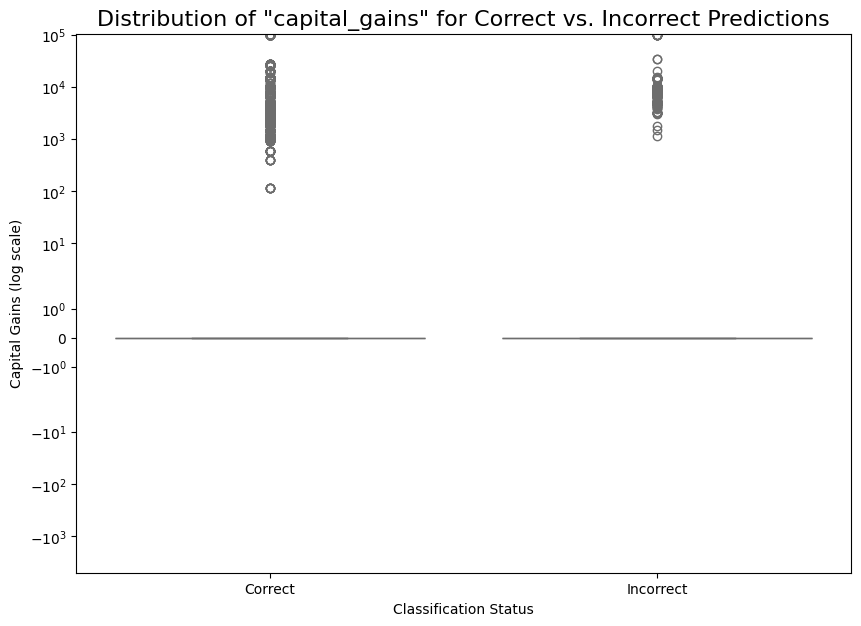

In [29]:
results_df['classification_status'] = 'Correct'
results_df.loc[errors_df.index, 'classification_status'] = 'Incorrect'

plt.figure(figsize=(10, 7))
sns.boxplot(x='classification_status', y='capital_gains', data=results_df, palette={'Correct': 'skyblue', 'Incorrect': 'salmon'}, hue='classification_status', legend=False)
plt.title('Distribution of "capital_gains" for Correct vs. Incorrect Predictions', fontsize=16)
plt.xlabel('Classification Status')
plt.yscale('symlog')
plt.ylabel('Capital Gains (log scale)')
plt.show()

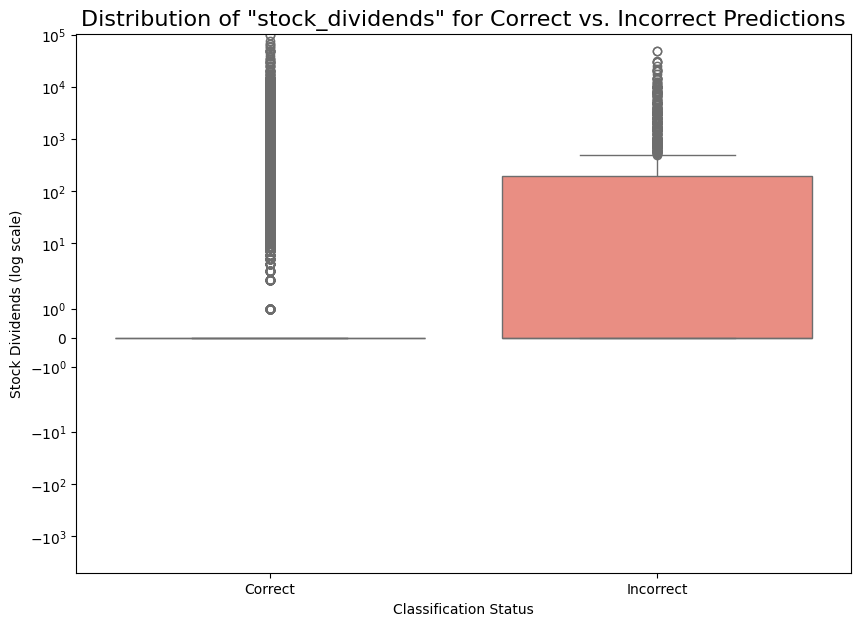

In [21]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='classification_status', y='stock_dividends', data=results_df, palette={'Correct': 'skyblue', 'Incorrect': 'salmon'}, hue='classification_status', legend=False)
plt.title('Distribution of "stock_dividends" for Correct vs. Incorrect Predictions', fontsize=16)
plt.xlabel('Classification Status')
# Use a symmetrical log scale
plt.yscale('symlog')
plt.ylabel('Stock Dividends (log scale)')
plt.show()

### Observations:

*   **Capital Gains (The Sparsity Problem):**
    *   The distributions for both correct and incorrect predictions are nearly identical: flattened at zero with high outliers in both groups.
    *   **Conclusion:** This confirms that while `capital_gains` is a powerful feature (as seen in SHAP), it is extremely sparse. The presence of outliers in the "Incorrect" group proves that high capital gains alone are **not a guaranteed discriminator**; the model sometimes fails to classify wealthy individuals correctly even when this strong signal is present.

*   **Stock Dividends (A Source of Confusion):**
    *   **Structural Difference:** There is a striking visual difference. While the "Correct" group is collapsed at zero, the "Incorrect" group shows a **significant spread** (visible boxplot), indicating that many misclassified samples possess non-zero stock dividends.
    *   **Key Insight:** This suggests that `stock_dividends` act as a **confounding factor**. The model struggles to contextually interpret investment income. It likely over-relies on this feature (predicting high income whenever dividends appear, leading to False Positives) or inconsistently weights it against other features, causing significant classification errors for investors.

### 7.5 `num_emp` distribution

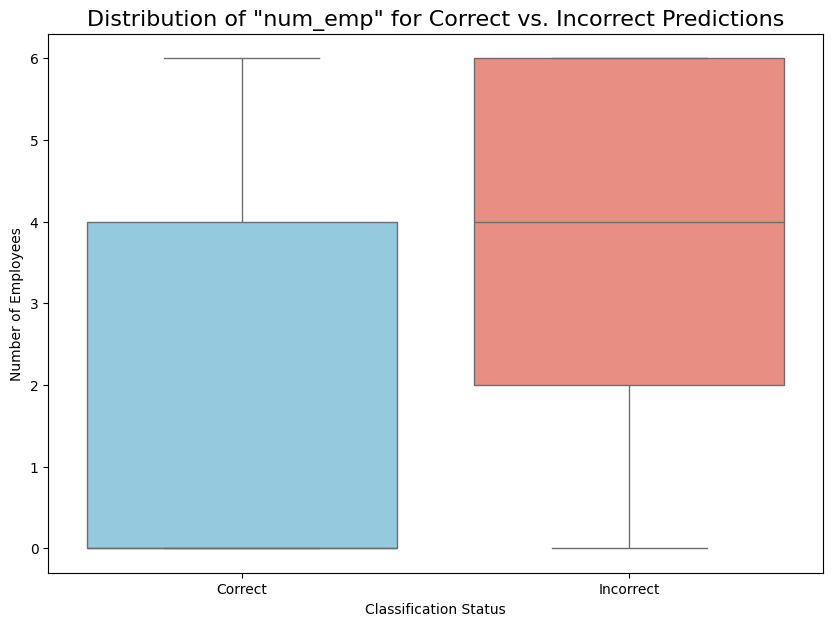

In [22]:
plt.figure(figsize=(10, 7))
sns.boxplot(x='classification_status', y='num_emp', data=results_df, palette={'Correct': 'skyblue', 'Incorrect': 'salmon'}, hue='classification_status', legend=False)
plt.title('Distribution of "num_emp" for Correct vs. Incorrect Predictions', fontsize=16)
plt.xlabel('Classification Status')
plt.ylabel('Number of Employees')
plt.show()

### Observations:
- **Correct Predictions (Blue):** The median is 0, and the box is concentrated in the lower range (0 to 4). This confirms the model is highly accurate when the employer size is small or zero (likely indicating individuals not in the workforce).
- **Incorrect Predictions (Red):** The distribution is shifted significantly higher. The median is around 4, and the interquartile range (the box) spans from 2 to 6.
- **Implication:** The model struggles most with individuals working for **medium to large employers** (values 4-6). While a value of 0 is an easy predictor for low income, larger employer sizes introduce ambiguity (e.g., a janitor vs. a CEO at a large corporation), leading to a higher rate of misclassification.

### 8. Conclusions

**1. Performance Context:**
The model achieved an F1-score of **0.58** for the minority class (`>50k`) and **0.62** weighted accuracy. While this indicates moderate performance in absolute terms, it represents a significant achievement given the severe class imbalance (15:1) and the intrinsic difficulty of the dataset. The model successfully avoids the "accuracy trap" of merely predicting the majority class, demonstrating real utility in identifying high earners.

**2. Data Limitations & Complexity:**
Predicting individual income is a highly complex task heavily influenced by factors not present in the dataset (e.g., family wealth, specific role hierarchy, inheritance, or soft skills). The available features are largely **indirect proxies** (e.g., education level is a proxy for skill, but not a guarantee of high salary). The lack of direct causal variables limits the theoretical maximum performance of any model on this specific data.

**3. Validation of Feature Engineering:**
The preprocessing and feature engineering phase was highly successful. The SHAP analysis confirms that **`net_capital`**—a custom-engineered feature—became the single most important predictor. This proves that aggregating financial gains and losses provided the model with a much stronger signal than raw data alone.

**4. Model Logic & Reliability:**
Despite the classification challenges, the model behaves rationally. It bases its decisions on **financial health** (Capital Gains/Losses, Investor status) and **workforce participation** (Weeks Worked), rather than relying on noise. This interpretability suggests that the model is robust and follows sound economic logic, even where it makes classification errors due to the "grey areas" in employment data (e.g., distinguishing between low-paid and high-paid professionals in large corporations).